# Generating Uniform Random Variables from Atmospheric Noise

A complementary notebook for the dissertation of the same name by Kirushanth Srithararajah
___

## Contents
 - 1. Analysis
 - 2. Gather Data
 - 3. Generate Uniform RVs
 - 4. NIST Testing Suite

## 1. Analysis

This notebook has been tested with the [NOOELEC](https://www.nooelec.com/store/sdr/nesdr-mini.html) USB (RTL-SDR) reciever. Before we can establish a connection to the reciever device, for use in Python, the [pyrtlsdr](https://pypi.org/project/pyrtlsdr/) library must be installed.

In [1]:
# import standard libraries
import numpy as np # for numeric manipulation 
import pandas as pd # for data manipulation 
from datetime import datetime # for date and time manipulation 
import matplotlib.pyplot as plt # for plotting results 
from matplotlib.ticker import ScalarFormatter
from pylab import * # for plotting results 
import seaborn as sns # for formatting plots 
import os # for manipulation of file paths
from IPython.display import clear_output # for clearing cell output
# import python library to connect to device
from rtlsdr import *

# check connection
sdr = RtlSdr()
sdr.close()

To use the device, we simply pass the following arguments:
 - center_freq (this is the carrier frequency we wish to sample)
 - sample_rate (how many samples we wish to take per second; default is `2.097e6`)
 - sample_size (how many samples do we want to take overall; default is `1.048e6`)
 - freq_correction (if the receiver is out of tune, we wish to add a correction; default is `60`)
 - gain (the level of amplification we are applying to the input signal; default is `'auto'`)

In [503]:
center_freq=25e6
sample_rate=2**20
sample_size=2**20
freq_correction=60
gain='auto'

# method for sampling
def rtl_sampler(f, g='auto', sample_size=sample_size):
    # connect to device
    sdr = RtlSdr()
    # pass arguments
    sdr.center_freq = f
    sdr.gain = g
    sdr.sample_rate = sample_rate
    sdr.freq_correction = freq_correction
    # take samples
    samples = sdr.read_samples(sample_size)
    # close connection
    sdr.close()
    return samples

Now, suppose we want a total of 2 million samples. There are many ways to achieve this, and we outline three such methods below. But first, which frequency do we choose and how do we set the gain? To help us decide, we try a range of carrier frequencies, then visualise them below. Note that the range we try is governed by the minimum (25Mhz) and maximum (1750Mhz) resolution of the device.

Further, the [OFCOM frequency allocation table](https://www.4gon.co.uk/documents/Ofcom_UKFAT2010.pdf) (page 83) states that the frequency band between 430 Mhz and 440 Mhz is reserved for amateur radiolocation in the UK. So to avoid any industrial level signals (i.e. FM radio, etc), we stick to this band.

In [131]:
# define range of freqencies
freqencies = [430e6, 435e6, 440e6]
# define range of gains
gains = [20, 30, 40, 50, 60]

samples_dict = {}
samples_concat = np.asarray([])

# define method
for f in freqencies: 
    for g in gains:
        # make a note of what's happening
        print('Sampling at {0} MHz and {1} gain... '.format(int(f/1e6), g), end='')
        # take samples
        samples = rtl_sampler(f, g, sample_size=2**18)
        # append samples
        samples_dict['{0}_{1}'.format(int(f/1e6), g)] = samples
        samples_concat = np.append(samples_concat, samples, axis=0)
        samples_concat = samples_concat.flatten()
        # make a note of what's happening
        n = len(samples_concat) 
        print('n = {0}'.format(n))
print('Done.')

Sampling at 430 MHz and 20 gain... n = 262144
Sampling at 430 MHz and 30 gain... n = 524288
Sampling at 430 MHz and 40 gain... n = 786432
Sampling at 430 MHz and 50 gain... n = 1048576
Sampling at 430 MHz and 60 gain... n = 1310720
Sampling at 435 MHz and 20 gain... n = 1572864
Sampling at 435 MHz and 30 gain... n = 1835008
Sampling at 435 MHz and 40 gain... n = 2097152
Sampling at 435 MHz and 50 gain... n = 2359296
Sampling at 435 MHz and 60 gain... n = 2621440
Sampling at 440 MHz and 20 gain... n = 2883584
Sampling at 440 MHz and 30 gain... n = 3145728
Sampling at 440 MHz and 40 gain... n = 3407872
Sampling at 440 MHz and 50 gain... n = 3670016
Sampling at 440 MHz and 60 gain... n = 3932160
Done.


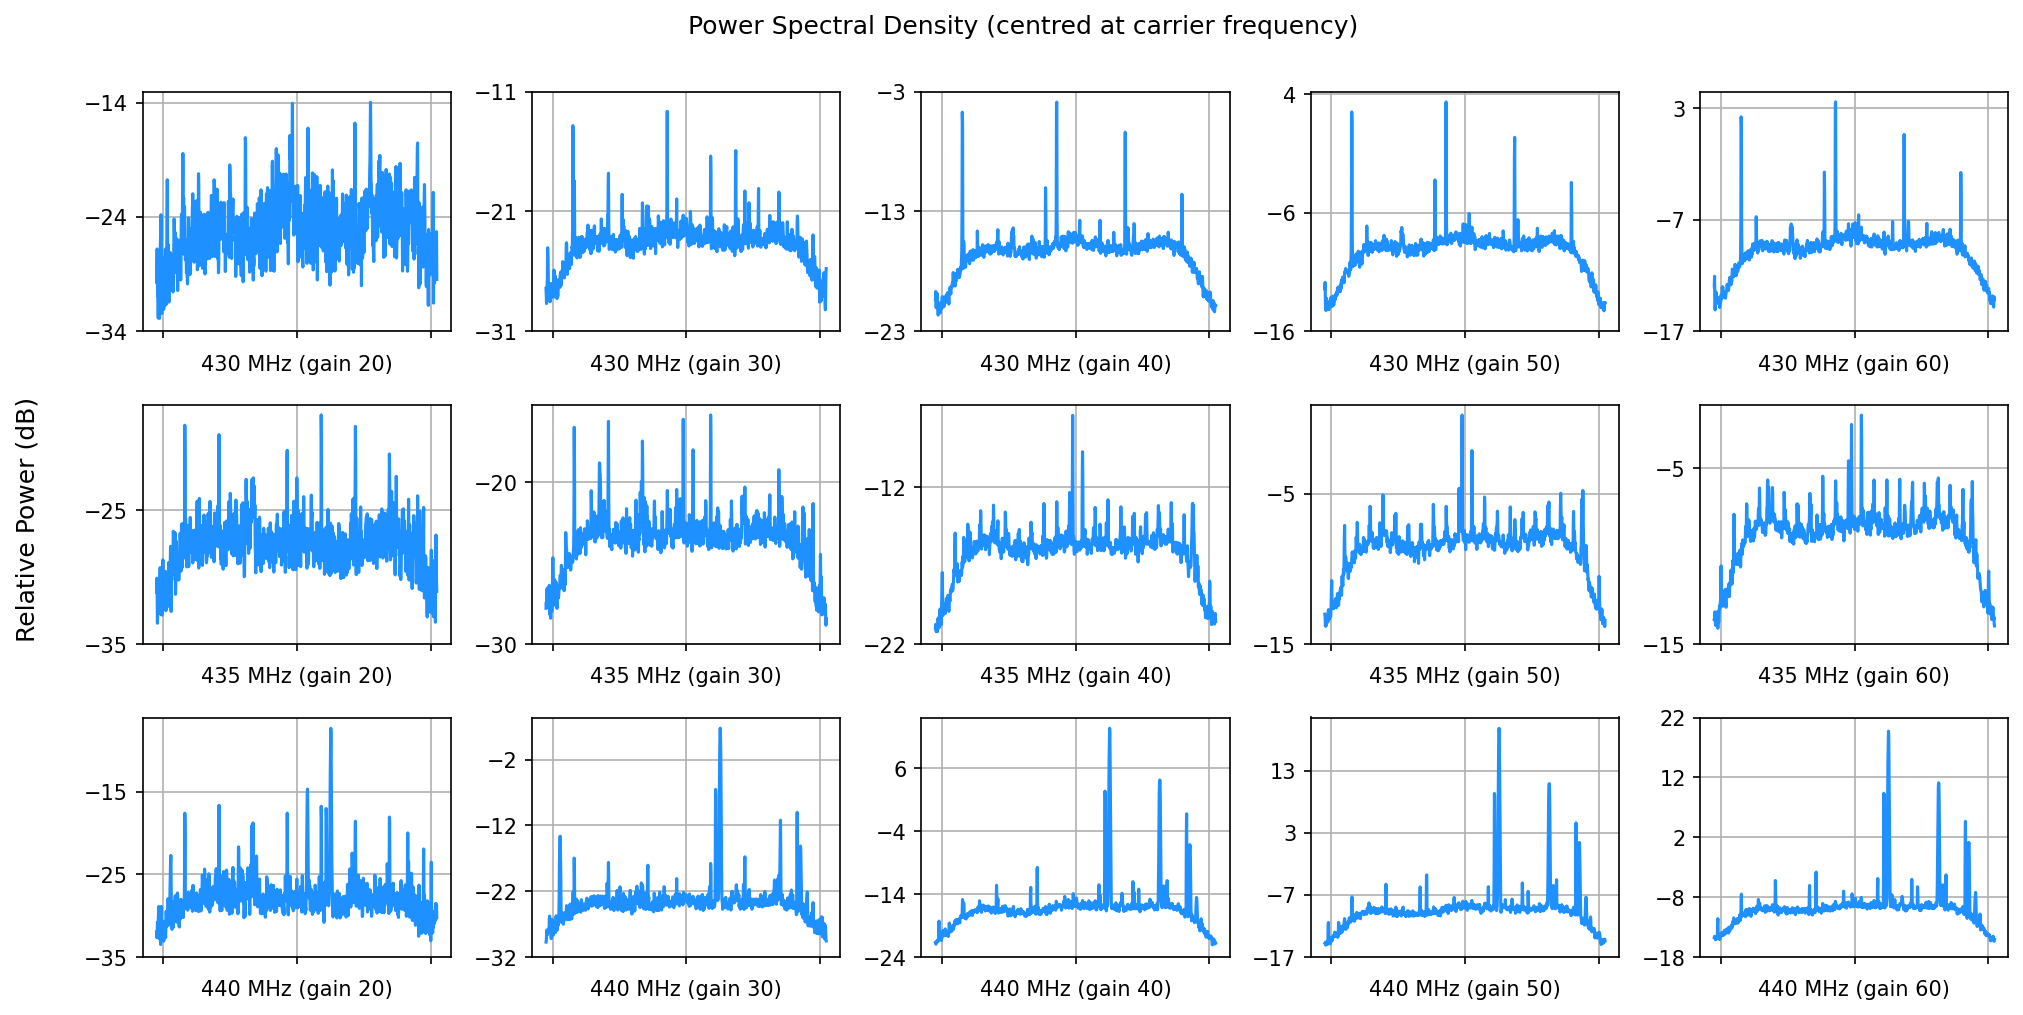

In [134]:
# plot results
fig = plt.figure(figsize=(14, 7), dpi=150)
i=1
for f in freqencies:
    for g in gains:
        ax = fig.add_subplot(3, 5, i)
        sample = samples_dict['{0}_{1}'.format(int(f/1e6), g)]
        plt.psd(sample, NFFT=1024, Fs=sample_rate/1e6, Fc=int(f/1e6), color='dodgerblue')
        ax.set_xlabel('{0} MHz (gain {1})'.format(int(f/1e6), g))
        ax.set_ylabel('')
        ax.set_xticklabels([])
        i+=1
fig.suptitle('Power Spectral Density (centred at carrier frequency)')
fig.supylabel('Relative Power (dB)')
plt.tight_layout(rect=[0.02, 0.02, 0.98, 0.98])
plt.show()
# plt.savefig('PSD.png')

We see that increasing the gain seems to reduce the noise. It also amplifies the signal, as expected (the y-axis decibel value increases as we pan right). We also see that the first two frequencies do not seem to differ much, but that there is a strong signal at 440Mhz. We drop this from our analysis. 

To better understand how this translates to the raw $IQ$ data, we plot the histogram of the values and try to ascertain their distribution.

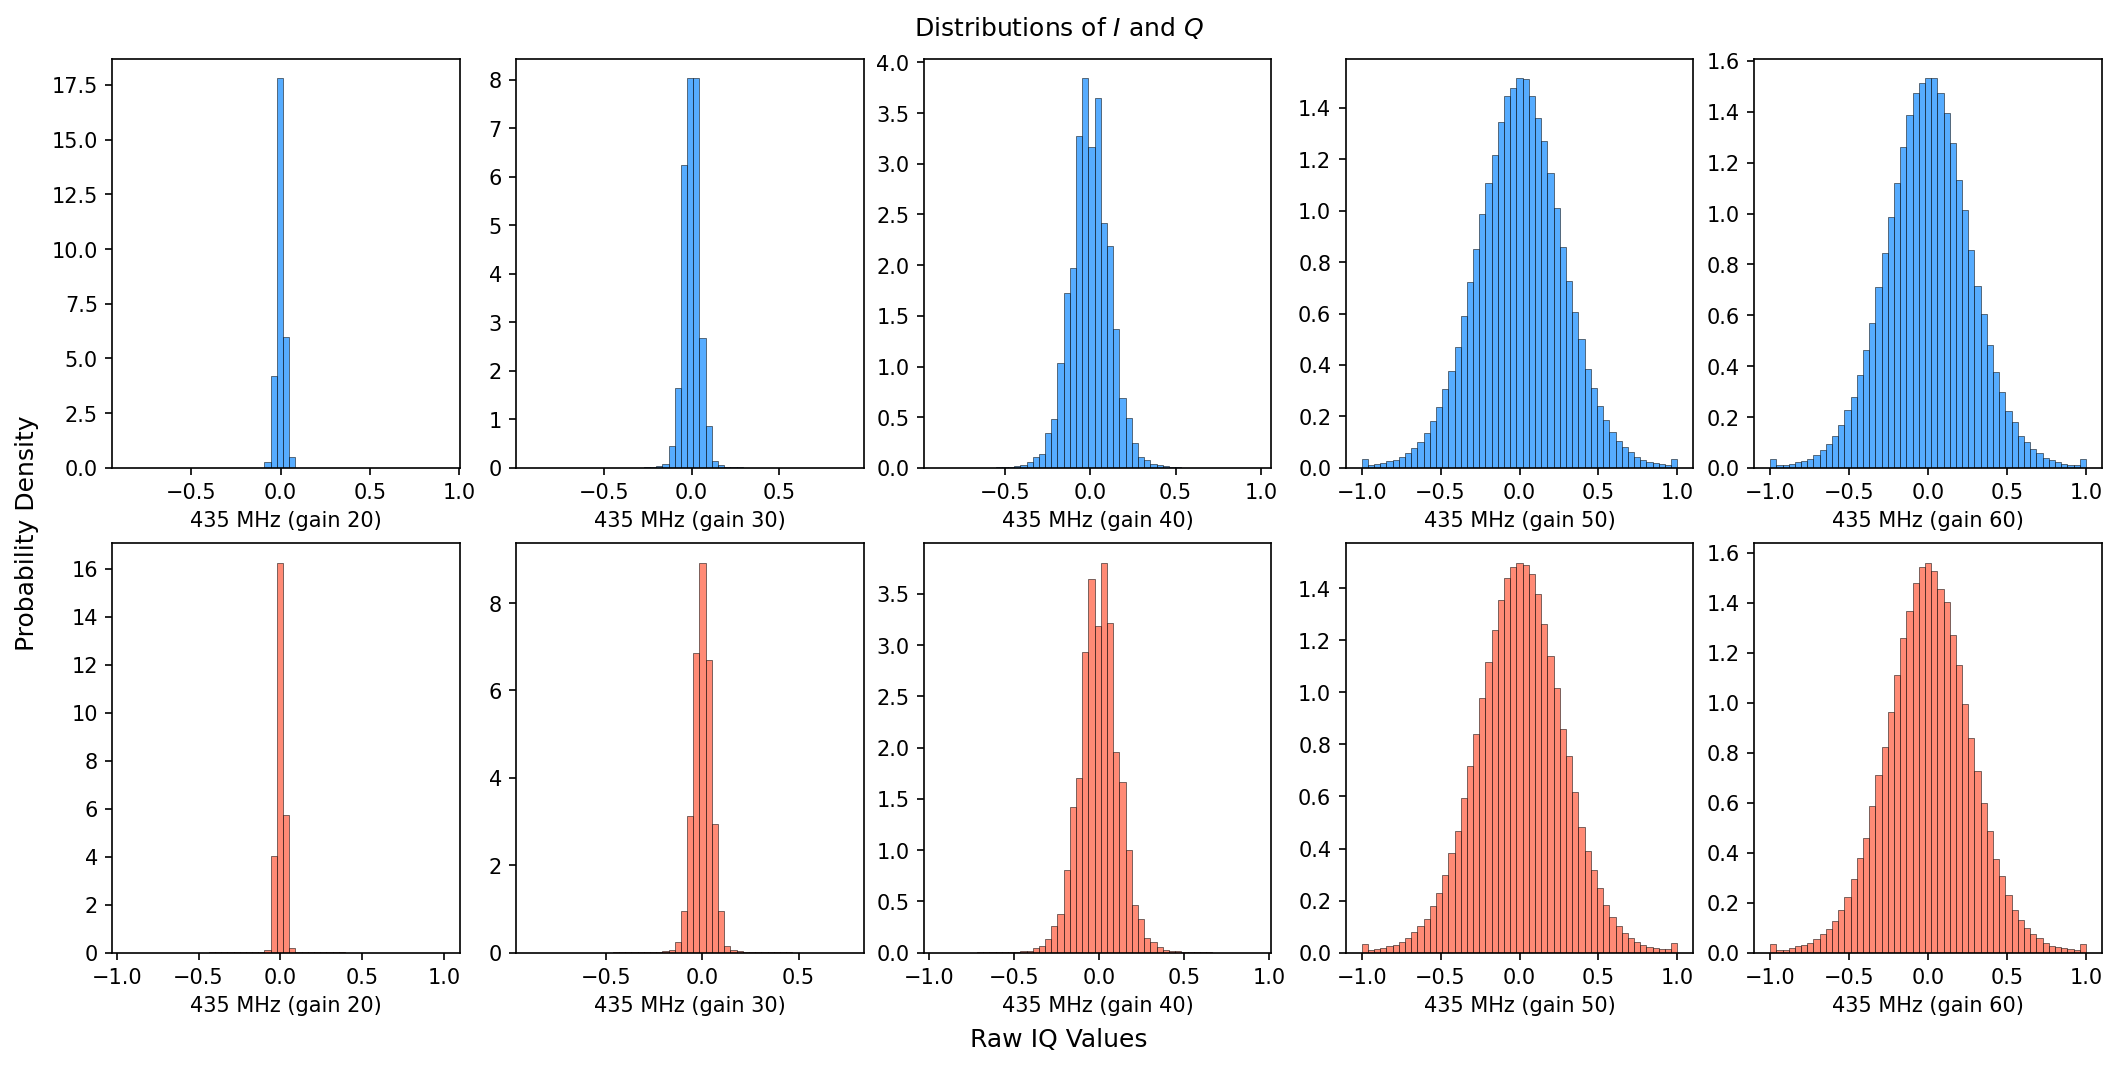

<Figure size 432x288 with 0 Axes>

In [189]:
# plot a grid of distribution by centre_frequency vs gain
fig = plt.figure(constrained_layout=True, figsize=(14, 7), dpi=150)
i=1
f = 435e6
for g in gains:
    sample = samples_dict['{0}_{1}'.format(int(f/1e6), g)]
    df = pd.DataFrame()
    df['real'] = sample.real
    df['imag'] = sample.imag
    # plot the real
    ax = fig.add_subplot(2, 5, i)
    sns.histplot(data=df, x='real', bins=51, stat="density", ax=ax, color='dodgerblue')
    ax.set_xlabel('{0} MHz (gain {1})'.format(int(f/1e6), g))
    ax.set_ylabel('')
    # plot the imag
    ax = fig.add_subplot(2, 5, i+5)
    sns.histplot(data=df, x='imag', bins=51, stat="density", ax=ax, color='tomato')
    ax.set_xlabel('{0} MHz (gain {1})'.format(int(f/1e6), g))
    ax.set_ylabel('')
    i+=1
fig.suptitle(r'Distributions of $I$ and $Q$')
fig.supxlabel('Raw IQ Values')
fig.supylabel('Probability Density')
# plt.tight_layout(rect=[0.02, 0.02, 0.98, 0.98])
plt.show()
# plt.savefig('distIQ.png')

The shape of the imaginary distributions are very similar to their real counterparts. In summary, the low gain sample (20 and below) do not appear deviate much from the mean and are centred around 0. The high gain samples (50 and above) seem to add variance to the $IQ$ values. This is a strange result as we expected there to be less noise with higher gain. Perhaps we have increased the gain too far, to the point of re-introducing noise. 

The samples also do not appear to be close enough to the normal distribution to be used directly. The general case seems to be that the distributions exhibit high kurtosis. Thus, we select 435Mhz at gain 40 to proceed.

## 2. Gather Data

A simple (but perhaps naive) method to gather data is to simply run the reciever continuously until we get enough samples

In [15]:
# define parameters
f = 435e6
g = 40

method = {}
method[1] = rtl_sampler(f, g, sample_size=2**20)

To try decrease the autocorrelation, instead we can take, say, only every $k$th data point in a sample and discard the rest. The algorithm is presented below:

- Define the first $k$ (in this case, we arbitrarily choose 7)
- Take a sample of length $2^{20}$ (or approx 1 million).
    - Take every $k$th element and discard the rest.
- Repeat until we have $2^{20}$ data points.

In [53]:
# set first k
k = 2**10 # 1024
sample_size = 2**20 # 1 million

# make a note of the time taken
start_time = datetime.datetime.now() 
# repeat until we hit the required sample size (this should take roughly 30 mins)
total_samples = np.asarray([])
n=0
fail_counter=10
while n < sample_size and fail_counter > 0:
    # make a note of what's happening
    now = datetime.datetime.now() 
    duration = now-start_time
    print('Sampling at {0} MHz, {1} gain and k = {2}... '.format(int(f/1e6), g, k), end='')
    print('n = {0} ({1}%). Time elapsed: {2}s'.format(n, np.round(n/sample_size)*100,2), duration.total_seconds())
    # take samples
    try:
        samples = rtl_sampler(f, g, sample_size)
        # take every kth value
        samples = samples[::k]
        # append samples
        total_samples = np.append(total_samples, samples, axis=0)
        # make a note of what's happening
        n = len(total_samples)
        clear_output()
    except:
        fail_counter -= 1
        print('Failed. Retry attempt {}'.format(10-fail_counter))  
    
if fail_counter > 0:
    print('Done.')
else:
    print('Failed. Please check settings and make sure the RTL device is connected.')
    
# trim samples
total_samples = total_samples[:sample_size]

Done.


In [58]:
# append samples
method[2] = total_samples

# save for reproducibility 
now = datetime.datetime.now() 
date_time = now.strftime("%d%m%Y_%H%M%S")
with open('data/method2/{0}.npy'.format(int(date_time)), 'wb') as file:
    np.save(file, total_samples) 

We also make note of the weather at the location during the sampling period. This is important as it has been shown that a large component of atmospheric noise is lightning strikes. Thus we record the cloud cover and thunderstorm likelihood as reported by [AccuWeather](https://www.accuweather.com/). During the sampling period we find that the cloud cover was at 72% and the thunderstorm likelihood was at 11%.

In [2]:
# if loading previous samples
method = {}
method[1] = np.load('data/method1/{}'.format([x for x in os.listdir('data/method1') if '.npy' in x][0]))
method[2] = np.load('data/method2/{}'.format([x for x in os.listdir('data/method2') if '.npy' in x][0]))

The benefit of method 2 is made clear below.

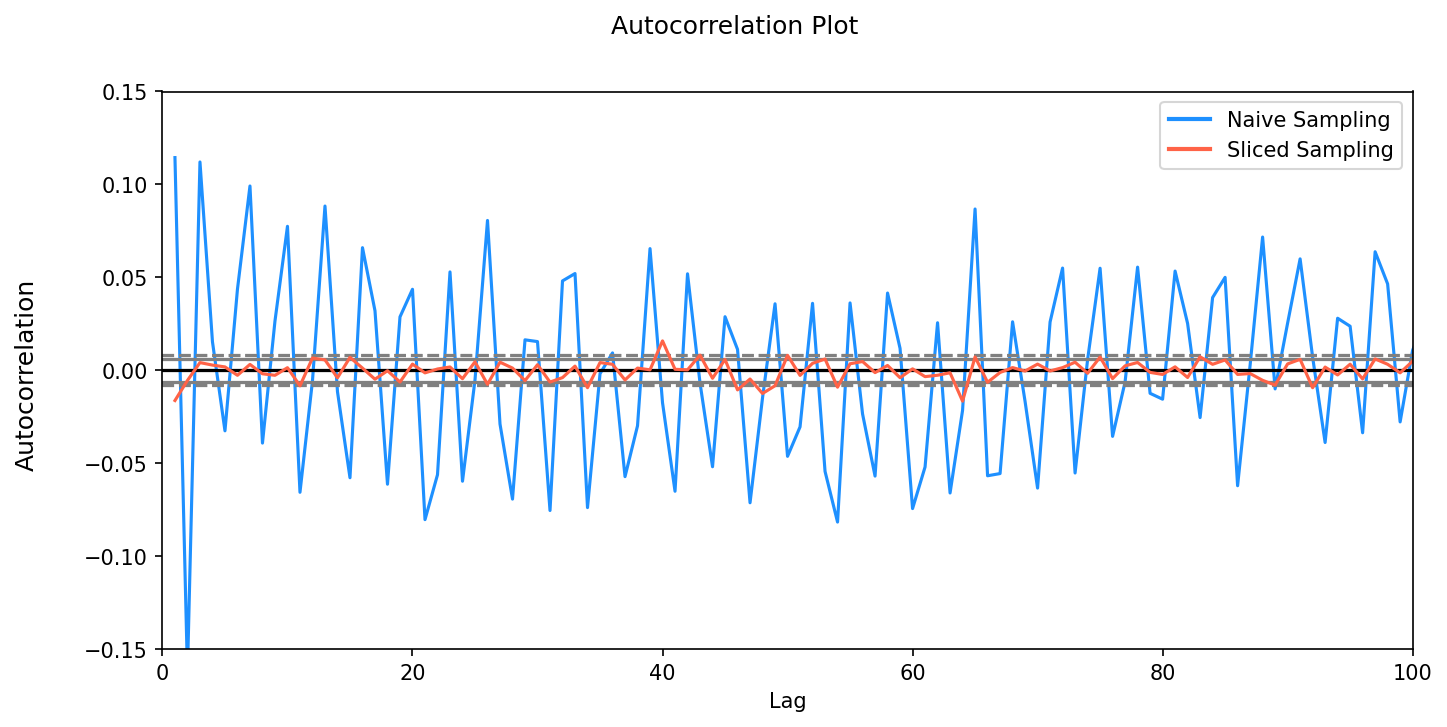

In [590]:
# plot autocorrelation plot
from pandas.plotting import autocorrelation_plot
fig, ax = plt.subplots(1, 1, figsize=(10,5), dpi=150)
colours = ['dodgerblue', 'tomato']
custom_legend = []

df = pd.DataFrame()
for m in [1,2]:
    sample = method[m]
    df[m] = sample.real
    autocorrelation_plot(df[m][:100000], ax=ax, c=colours[m-1])
    custom_legend.append((ax.get_lines()[-1].get_color()))
plt.xlim(0, 100)
plt.ylim(-0.15, 0.15)
ax.set_ylabel('')

custom_lines = [
    Line2D([0],[0], color=custom_legend[0], lw=2),
    Line2D([0],[0], color=custom_legend[1], lw=2)
]
ax.legend(custom_lines, ['Naive Sampling', 'Sliced Sampling'])

fig.suptitle(r'Autocorrelation Plot')
fig.supylabel('Autocorrelation')
plt.tight_layout(rect=[0.02, 0.02, 0.98, 0.98])
plt.show()
# plt.savefig('autocorrelation.png')

## 3. Generate Uniform RVs

There are many methods for generating uniform random variables from independant normal pairs. We explore 4 such methods. The Python Random library provides draws from a pseudorandom uniform distribution, via the use of the Mersenne Twister algorithm. It also provides draws from a pseudorandom normal distribution. We will also use this as a benchmark of sorts in our plots below.

First, we must test for independence between the $I$ and $Q$ values. This is not easy to do, but for the purpose of this study we simply look for correlation. In particular, we use [Spearman's](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) rank correlation as it does not assume normality. 

In [200]:
df = pd.DataFrame()
df['real'] = method[2].real
df['imag'] = method[2].imag
df.corr(method='spearman')

,real,imag
real,1.000000,-0.001079
imag,-0.001079,1.000000


Clearly the $I$'s and the $Q$'s are not correlated. Also, since the samples are not (standard) normally distributed, so we also test the normality of these samples _after_ standardising. To do this, we use the [Kolmogorov-Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test) from [scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html).

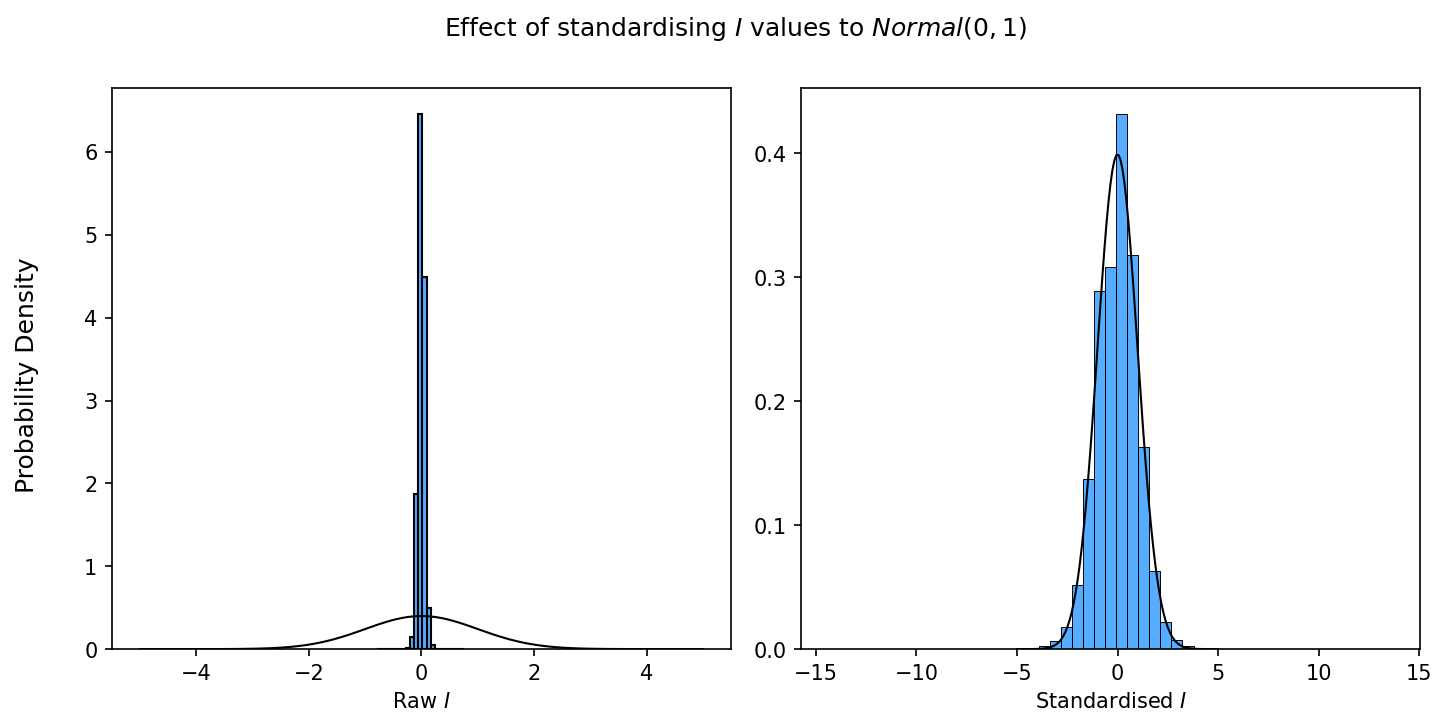

In [199]:
from scipy import stats
rv = stats.norm()
x = np.linspace(-5,5,100)
fig, axes = plt.subplots(1, 2, figsize=(10,5), dpi=150)

km_result = {}

# plot distribution as is 
ax = axes.flatten()[0]
sample = method[2]
df = pd.DataFrame()
df['vals'] = sample.real
sns.histplot(data=df, x='vals', bins=21, stat="density", ax=ax, color='dodgerblue')
ax.plot(x, rv.pdf(x), 'k-', lw=1, label='Normal')
ax.set_xlabel(r'Raw $I$')
ax.set_ylabel('')

# standardise
x_mu = np.mean(sample.real)
x_std = np.std(sample.real)
sample = (sample.real-x_mu)/x_std

# run KM test for normality
km_result['Method 2'] = stats.kstest(sample.real, 'norm')

# plot standardised distribution
ax = axes.flatten()[1]
df = pd.DataFrame()
df['vals'] = sample
sns.histplot(data=df, x='vals', bins=51, stat="density", ax=ax, color='dodgerblue')
ax.plot(x, rv.pdf(x), 'k-', lw=1, label='Normal')
ax.set_xlabel(r'Standardised $I$')
ax.set_ylabel('')

fig.suptitle(r'Effect of standardising $I$ values to $Normal(0,1)$')
fig.supylabel('Probability Density')
plt.tight_layout(rect=[0.02, 0.02, 0.98, 0.98])
plt.show()
# plt.savefig('standardising.png')

In [194]:
km_result

{'Method 2': KstestResult(statistic=0.039385015680740376, pvalue=0.0)}

We see that although $I$ appears normal when binned, it fails the Kolmogorov-Smirnov test ($p$-value << 0.01). Thus some of the methods used below to generate uniform random variables may fail as a common assumption made is that the input data is normally distributed.

Still, we assume that $I$ and $Q$ are normally-distributed and independant.



### Comparison with random.org

[random.org](https://www.random.org/) utilises atmospheric noise to provide TRNGs on their website; often used for competitive draws and random sampling in medical studies. The service has radio antennae situated around the world and then a proprietary and confidential method is used to generate bits of entropy using the data gathered. The free version of the service provides a maximum of 10,000 bits at a time. 

We use the premium service to generate 1 million uniform samples (with 8 decimal places) for $21.91. It takes around 24 minutes for the numbers to be generated.

In [3]:
# import random.org data
df = pd.read_csv('data/random_org/random_org.txt', header=None)
df.columns = ['random_org']
method[3] = df


### Method 1: Reverse Box–Muller
The [Box–Muller](https://en.wikipedia.org/wiki/Box%E2%80%93Muller_transform) transform is a method to of generating pairs of independent, standard, normally distributed random numbers from a uniform random source. We will reverse the procedure. It consists of:

 - Standardising our $IQ$ values so that they are $X\sim N(0,1)$ and $Y \sim N(0,1)$, respectively.
 - For each pair $x_i, y_i$, calculating the following: $$u_i = \exp{\left(\frac{-(x_i^2+y_i^2)}{2}\right)}$$
 
The resulting $u_i$'s should be from the uniform distribution $U_{[0,1]}$.

In [293]:
def uniforms_from_RBM(x,y):
    """
    Reverses the Box-Muller method to return uniform random variables from 
    pairs of independent standard normals.
    Arguments: 
     - x (array of floats, length same as y)
     - y (array of floats, length same as x)
    Returns:
     - uniforms (array of floats)
    """
    if len(x) != len(y):
        print('Error: len(x) not the same as len(y).')
    else:
        # scale to standard normal
        x_mu = np.mean(x)
        x_sigma = np.std(x)
        y_mu = np.mean(y)
        y_sigma = np.std(y)
        x_standard = (x-x_mu)/x_sigma
        y_standard = (y-y_mu)/y_sigma

        # reverse Box–Muller
        uniforms = []
        for i in range(len(x)):
            u = np.exp(-1*(x_standard[i]**2+y_standard[i]**2)/2)
            uniforms.append(u)
        return uniforms

In [294]:
%%timeit
u = uniforms_from_RBM(method[2].real, method[2].imag)

2.06 s ± 45.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


As suspected, the violation of normaility means this method does not work for our samples. The PRNG generated normal variates show that given the assumptions hold, this method does indeed work to produce uniform random variable. We explore other, more robust methods to see if this pattern continues.

### Method 2: Beta(1,1)
The uniform distribution $U[0,1]$ is a special case of the Beta distribution. To see this, let the random variable $X\sim\text{Beta}\left(\alpha,\beta \right)$. For $0<x<1$, the probability density function of the Beta distribution is defined as 
$$f(x) = \frac{x^{\alpha-1}(1-x)^{\beta-1}}{\Gamma(\alpha)\Gamma(\beta)},$$
where $\Gamma(n) = (n-1)!$ is the [gamma function](https://en.wikipedia.org/wiki/Gamma_function).

Note that setting $\alpha=\beta=1$ yields
$$f(x) = \frac{x^{0}(1-x)^{0}}{\Gamma(1)\Gamma(1)} = \frac{1(1)}{1(1)} = 1.$$

This is exactly the probability density function of a standard uniform random variable. We can leverage this fact to generate uniform random variables by:

 - Standardising our $IQ$ values so that they are $X\sim N(0,1)$ and $Y \sim N(0,1)$, respectively.
 - For each pair $x_i, y_i$, squaring them and summing the result to get $z_i \sim \chi^2$ (by definition).
 - For each $z_i$, calculating the following: $$u_i = \frac{z_{2i}}{z_{2i-1} + z_{2i}}$$

The resulting $u_i$'s should be from the uniform distribution $U_{[0,1]}$.

In [289]:
def uniforms_from_BETA(x,y):
    """
    Uses the fact that the uniform distribution is a special case of the Beta 
    distribution to generate uniform random variables.
    Arguments: 
     - x (array of floats, length same as y)
     - y (array of floats, length same as x)
    Returns:
     - uniforms (array of floats)
    """
    if len(x) != len(y):
        print('Error: len(x) not the same as len(y).')
    else:
        # scale to standard normal
        x_mu = np.mean(x)
        x_sigma = np.std(x)
        y_mu = np.mean(y)
        y_sigma = np.std(y)
        x_standard = (x-x_mu)/x_sigma
        y_standard = (y-y_mu)/y_sigma

        # square to get chi^2
        chi2 = []
        for i in range(len(x)):
            z = x_standard[i]**2 + y_standard[i]**2
            chi2.append(z)
        
        # form beta RVs
        uniforms = []
        for i in range(len(chi2)):
            try:
                u = chi2[2*i]/(chi2[2*i-1] + chi2[2*i])
                uniforms.append(u) 
            except:
                pass
            
        return uniforms

In [291]:
%%timeit
u = uniforms_from_BETA(method[2].real, method[2].imag)

973 ms ± 29.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


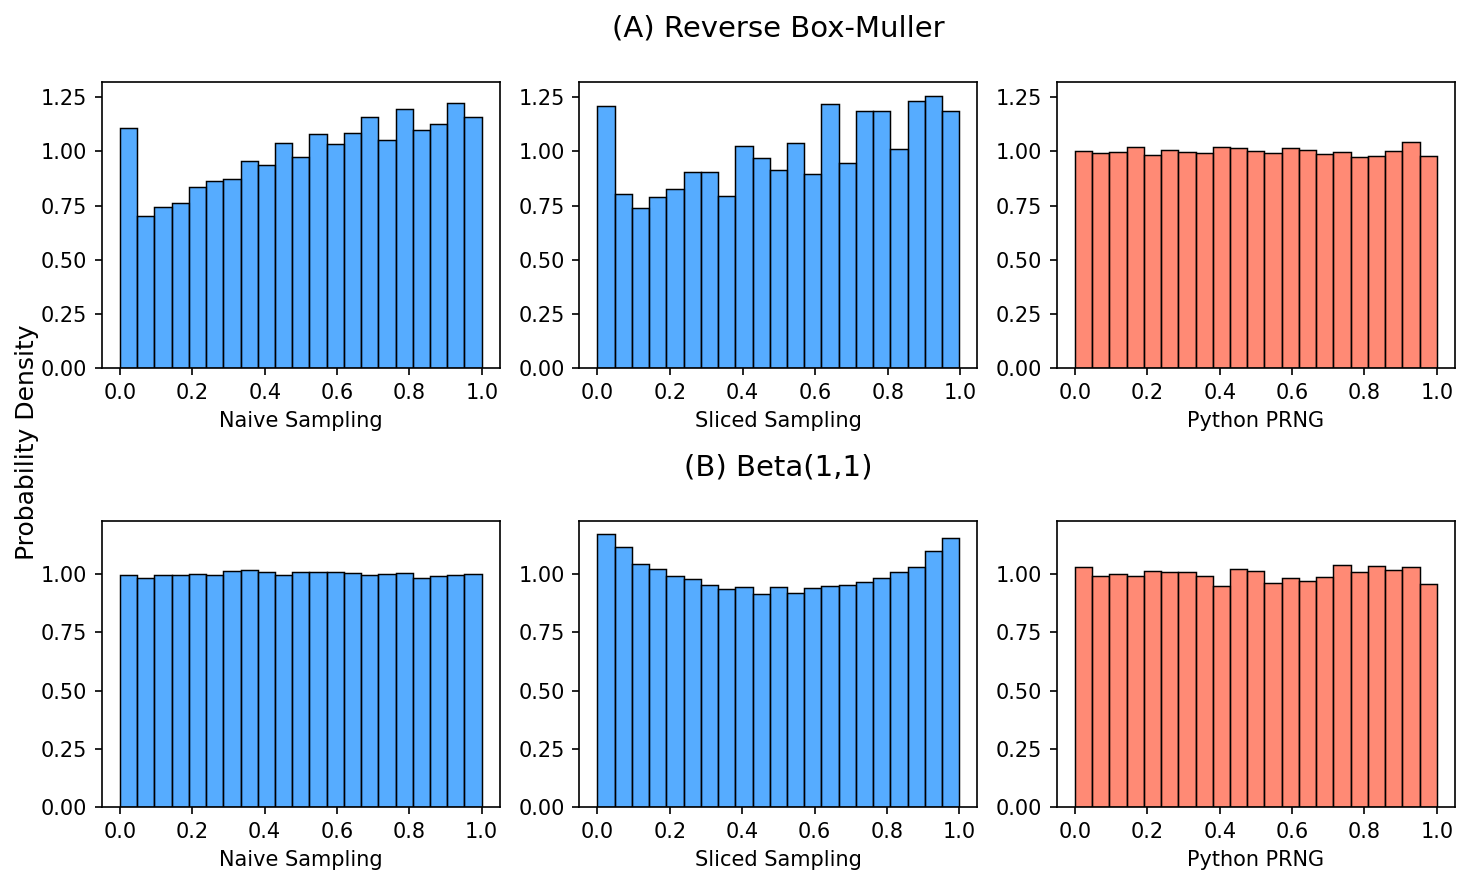

In [295]:
# plots for pdf
import matplotlib.gridspec as gridspec
x_prng, y_prng = np.random.normal(0, 1, 100000), np.random.normal(0, 1, 100000)

fig = plt.figure(figsize=(10, 6), dpi=150)
grid = plt.GridSpec(2, 1)

for i in range(2):
    # create fake subplot just to title set of subplots
    fake = fig.add_subplot(grid[i])
    if i == 0:
        fake.set_title(r'(A) Reverse Box-Muller'+f'\n', size=14)
        fake.set_axis_off()
        func='RBM'
    elif i == 1:
        fake.set_title(r'(B) Beta(1,1)'+f'\n', size=14)
        fake.set_axis_off()
        func='BETA'

    # create subgrid for two subplots without space between them
    # <https://matplotlib.org/2.0.2/users/gridspec.html>
    gs = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=grid[i])
    
    # real subplot #1
    ax = fig.add_subplot(gs[0])
    x, y = method[1].real, method[1].imag
    if func == 'RBM':
        uniforms = uniforms_from_RBM(x,y)
    else:
        uniforms = uniforms_from_BETA(x,y)
    df = pd.DataFrame()
    df['vals'] = uniforms
    sns.histplot(data=df, x='vals', bins=21, stat="density", ax=ax, color='dodgerblue')
    ax.set_xlabel(r'Naive Sampling')
    ax.set_ylabel('')
    
    # real subplot #2
    ax = fig.add_subplot(gs[1], sharey=ax)
    x, y = method[2].real, method[2].imag
    if func == 'RBM':
        uniforms = uniforms_from_RBM(x,y)
    else:
        uniforms = uniforms_from_BETA(x,y)
    df = pd.DataFrame()
    df['vals'] = uniforms
    sns.histplot(data=df, x='vals', bins=21, stat="density", ax=ax, color='dodgerblue')
    ax.set_xlabel(r'Sliced Sampling')
    ax.set_ylabel('')

    # real subplot #3
    ax = fig.add_subplot(gs[2], sharey=ax)
    x, y = x_prng, y_prng
    if func == 'RBM':
        uniforms = uniforms_from_RBM(x,y)
    else:
        uniforms = uniforms_from_BETA(x,y)
    df = pd.DataFrame()
    df['vals'] = uniforms
    sns.histplot(data=df, x='vals', bins=21, stat="density", ax=ax, color='tomato')
    ax.set_xlabel('Python PRNG')
    ax.set_ylabel('')
    
fig.supylabel('Probability Density')
fig.patch.set_facecolor('white')
fig.tight_layout()
plt.show()
# plt.savefig('norm_to_unif.png')

This method delivers much more consistent results. However, it is strange that this method works for method 1 but not 2. It is also a much faster implementation (over 2x faster), despite having two loops compared to the Box-Muller method's single loop.

Unfortunately, the results aren't as good as we were expecting. Thus, we now attempt random bit extraction in order to create a non-biased generator of 1's and 0's. We can then then use these random bits to generate uniform random variables.

### Random Bit Extraction

#### Von Neumann Bit Extractor

There are many different algorithms for bit sampling and research is still ongoing to reduce wasted bits and improve the entropy gathered, but we use the following simple approach first described by von Neumann:

- Given a stream of bits:
|   |   |   |   |
|:-:|:-:|:-:|:-:|
|$00\to\Lambda$ | $01\to0$ | $10\to1$ | $11\to\Lambda$|

($\Lambda$ means to discard the pair). On average, if we assume that the inputs are independant and not correlated at all, we lose 75% of the data.

#### Elias Bit Extractor
Another popular method is to use Elias's mapping. He suggests we use blocks of $N$ bits rather than pairs. This has the benefit of wasting less bits than Von Neumann's method. Here is the mapping for $N=4$:

|   |   |   |   |
|:-:|:-:|:-:|:-:|
|$0000\to\Lambda$ | $0001\to 11$ | $1111\to \Lambda$ | $1110\to 00$|
|$1000\to 00$ | $1100\to 1$ | $0111\to 01$ | $0011\to 01$|
|$0100\to 01$ | $0101\to 0$ | $1011\to 10$ | $1010\to 10$|
|$0010\to 10$ | $0110\to 00$ | $1101\to 11$ | $1001\to 11$|



In [68]:
vn_map = {
    0:[None],
    1:[0],
    2:[1],
    3:[None]
}


el_map = {
    0:[None],
    1:[1,1],
    2:[1,0],
    3:[0,1],
    4:[0,1],
    5:[0],
    6:[0,0],
    7:[0,1],
    8:[0,0],
    9:[1,1],
    10:[1,0],
    11:[1,0],
    12:[1],
    13:[1,1],
    14:[0,0],
    15:[None]
}

In [123]:
def rbe(x,y,method='VN',verbose=False):
    """
    A random bit extractor that generates unbiased 1's and 0's.
    Arguments: 
     - x (array of floats, length same as y)
     - y (array of floats, length same as x)
     - method (a string to tell the function which method to use)
    Returns:
     - bits (array of binary integers 1 or 0)
    """
    if len(x) != len(y):
        print('Error: len(x) not the same as len(y).')
    else:
        # first turn the decimal x's and y's into binary 1's and 0's by simply checking if they are
        # larger than the mean (-> 1) or less than the mean (-> 0)
        x_mu = np.mean(x)
        y_mu = np.mean(y)
        xbits = np.heaviside(x, x_mu).astype(int)
        ybits = np.heaviside(y, y_mu).astype(int)
        # extract random bits using von Neumann
        if method == 'VN':
            # turn to strings
            xbits = [str(x) for x in xbits]
            ybits = [str(y) for y in ybits]
            # join together
            xybits = np.asarray([int(x+y,2) for x,y in zip(xbits,ybits)])
            # apply mapping
            u,inv = np.unique(xybits,return_inverse = True)
            bits = np.array([vn_map[x] for x in u], dtype=object)[inv].reshape(xybits.shape)
        # extract random bits using Elias
        elif method == 'EL':   
            # turn to strings
            xbits = np.array_split(xbits,len(xbits)/2)
            xbits = [str(x[0]) + str(x[1]) for x in xbits]
            ybits = np.array_split(ybits,len(ybits)/2) 
            ybits = [str(y[0]) + str(y[1]) for y in ybits]
            # join together
            xybits = np.asarray([int(x+y,2) for x,y in zip(xbits,ybits)])
            # apply mapping
            u,inv = np.unique(xybits,return_inverse = True)
            bits = np.array([el_map[x] for x in u], dtype=object)[inv].reshape(xybits.shape)
            # flatten list
            bits = np.concatenate(bits).ravel()
        else:
            print(
            f"""
            Error: unknown method "{method}". Please use one of the following:
             - 'VN': von Neumann
             - 'XOR': Exclusive OR
            """
            )
        # remove null values
        bits = [x for x in bits if x != None]
        if verbose == True:
            print(mean(bits), len(bits)/(len(x) + len(y)))
        return bits

Now that we have our random bits extracted from $IQ$, we again apply a transform to the uniform distribution. There are two methods transformations we explore.

#### Decimal Representation of Bytes (8BIT)
Perhaps the simplest transformation is to split the bit stream into 8-bit (or byte) chunks. Each byte can then be read as the decimal representation of an 8-bit number (i.e. from 0 to 255). The following algorithm explains this in detail.

- Split the input bit-stream into 8-bit arrays. Each array then represents a number in binary from 0 (00000000) to 255 (11111111). 
- Convert each array into decimal and then divide by 255.
- The result should be uniformly distributed on [0,1].

In [284]:
def uniforms_from_8BIT(bits):
    """
    This algorithm splits an input list into 8-bit blocks
    and converts each to the decimal representation.
    Arguments: 
     - bits (a list of random bits , 1 or 0)
    Returns:
     - uniforms (a list of reals in Uniform [0 ,1])
    """
    # split into 8 bit chunks
    length = 8 * round(len(bits) / 8)
    # exclude the end if not exactly divisible by 8
    bits = bits[:length]
    bitlist = np.array_split(bits, length / 8)
    # generate uniforms
    uniforms = []
    for j in bitlist:
        uniforms.append(int(''.join([str(i) for i in j]),2) / 255)
    return uniforms

#### Fast Dice Roller (FDR)
The fast dice roller is an algorithm by [Lumbroso, 2013](https://arxiv.org/pdf/1304.1916.pdf). We have adapted the pseudocode given in the paper.

In [285]:
def fdr(n, flip):
    """
    The Fast Dice Roller algorithm adapted from the pseudocode 
    given in Lumbroso, 2013.
    Arguments: 
     - n (the range of uniform integers we wish to generate)
     - flip (an iterable that returns 1 or 0 when called)
    Returns:
     - c (an integer in Uniform[0,n])
    """
    v, c = 1, 0
    while True:
        v = 2 * v
        c = 2 * c + next(flip)
        if v >= n:
            if c < n:
                return c
            else:
                v = v - n
                c = c - n
                
def uniforms_from_FDR(bits):
    """
    Use the FDR algorithm to generate uniforms from a random bit source.
    Arguments: 
     - bits (a list of random bits, 1 or 0)
    Returns:
     - uniforms (a list of reals in Uniform[0,1])
    """
    iterator = iter(bits)
    enough_bits = True
    uniforms = []
    while enough_bits:
        try:
            k = fdr(255, iterator)
            uniforms.append(k)
        except:
            enough_bits = False
    uniforms = [i / 255 for i in uniforms]
    return uniforms

In [269]:
%%timeit

u8 = generate_8(bits)

684 ms ± 17.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Test both methods above.

In [286]:
def bits_to_unif(x,y,rbe_method='VN',unif_method='FDR',verbose=False):
    """
    Uses the randomly extracted bits to generate uniform random variables.
    Arguments: 
     - x (array of bits, length same as y)
     - y (array of bits, length same as x)
    Returns:
     - uniforms (array of floats)
    """
    if len(x) != len(y):
        print('Error: len(x) not the same as len(y).')
    else:
        # first, apply RBE on x and y
        if rbe_method == 'VN':
            bits = rbe(x,y,method='VN')
        elif rbe_method == 'EL':   
            bits = rbe(x,y,method='EL')
        else:
            print(
            f"""
            Error: unknown RBE method "{method}". Please use one of the following:
             - 'VN': von Neumann
             - 'XOR': Exclusive OR
            """
            )
            return None
        if verbose == True:
            print(mean(bits), len(bits))
        # then, apply a transformation to uniform
        if unif_method == 'FDR':
            uniforms = uniforms_from_FDR(bits)
            return uniforms
        elif unif_method == '8BIT':
            uniforms = uniforms_from_8BIT(bits)
            return uniforms
        else:
            print(
            f"""
            Error: unknown Uniform transformation "{method}". Please use one of the following:
             - 'FDR': Fast Dice Roller
             - '8BIT': Decimal represention of 8 bits
            """
            )
            return None


<ipython-input-123-f2b94a2e489e>:42: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bits = np.array([el_map[x] for x in u])[inv].reshape(xybits.shape)
<ipython-input-123-f2b94a2e489e>:42: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bits = np.array([el_map[x] for x in u])[inv].reshape(xybits.shape)
<ipython-input-123-f2b94a2e489e>:42: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

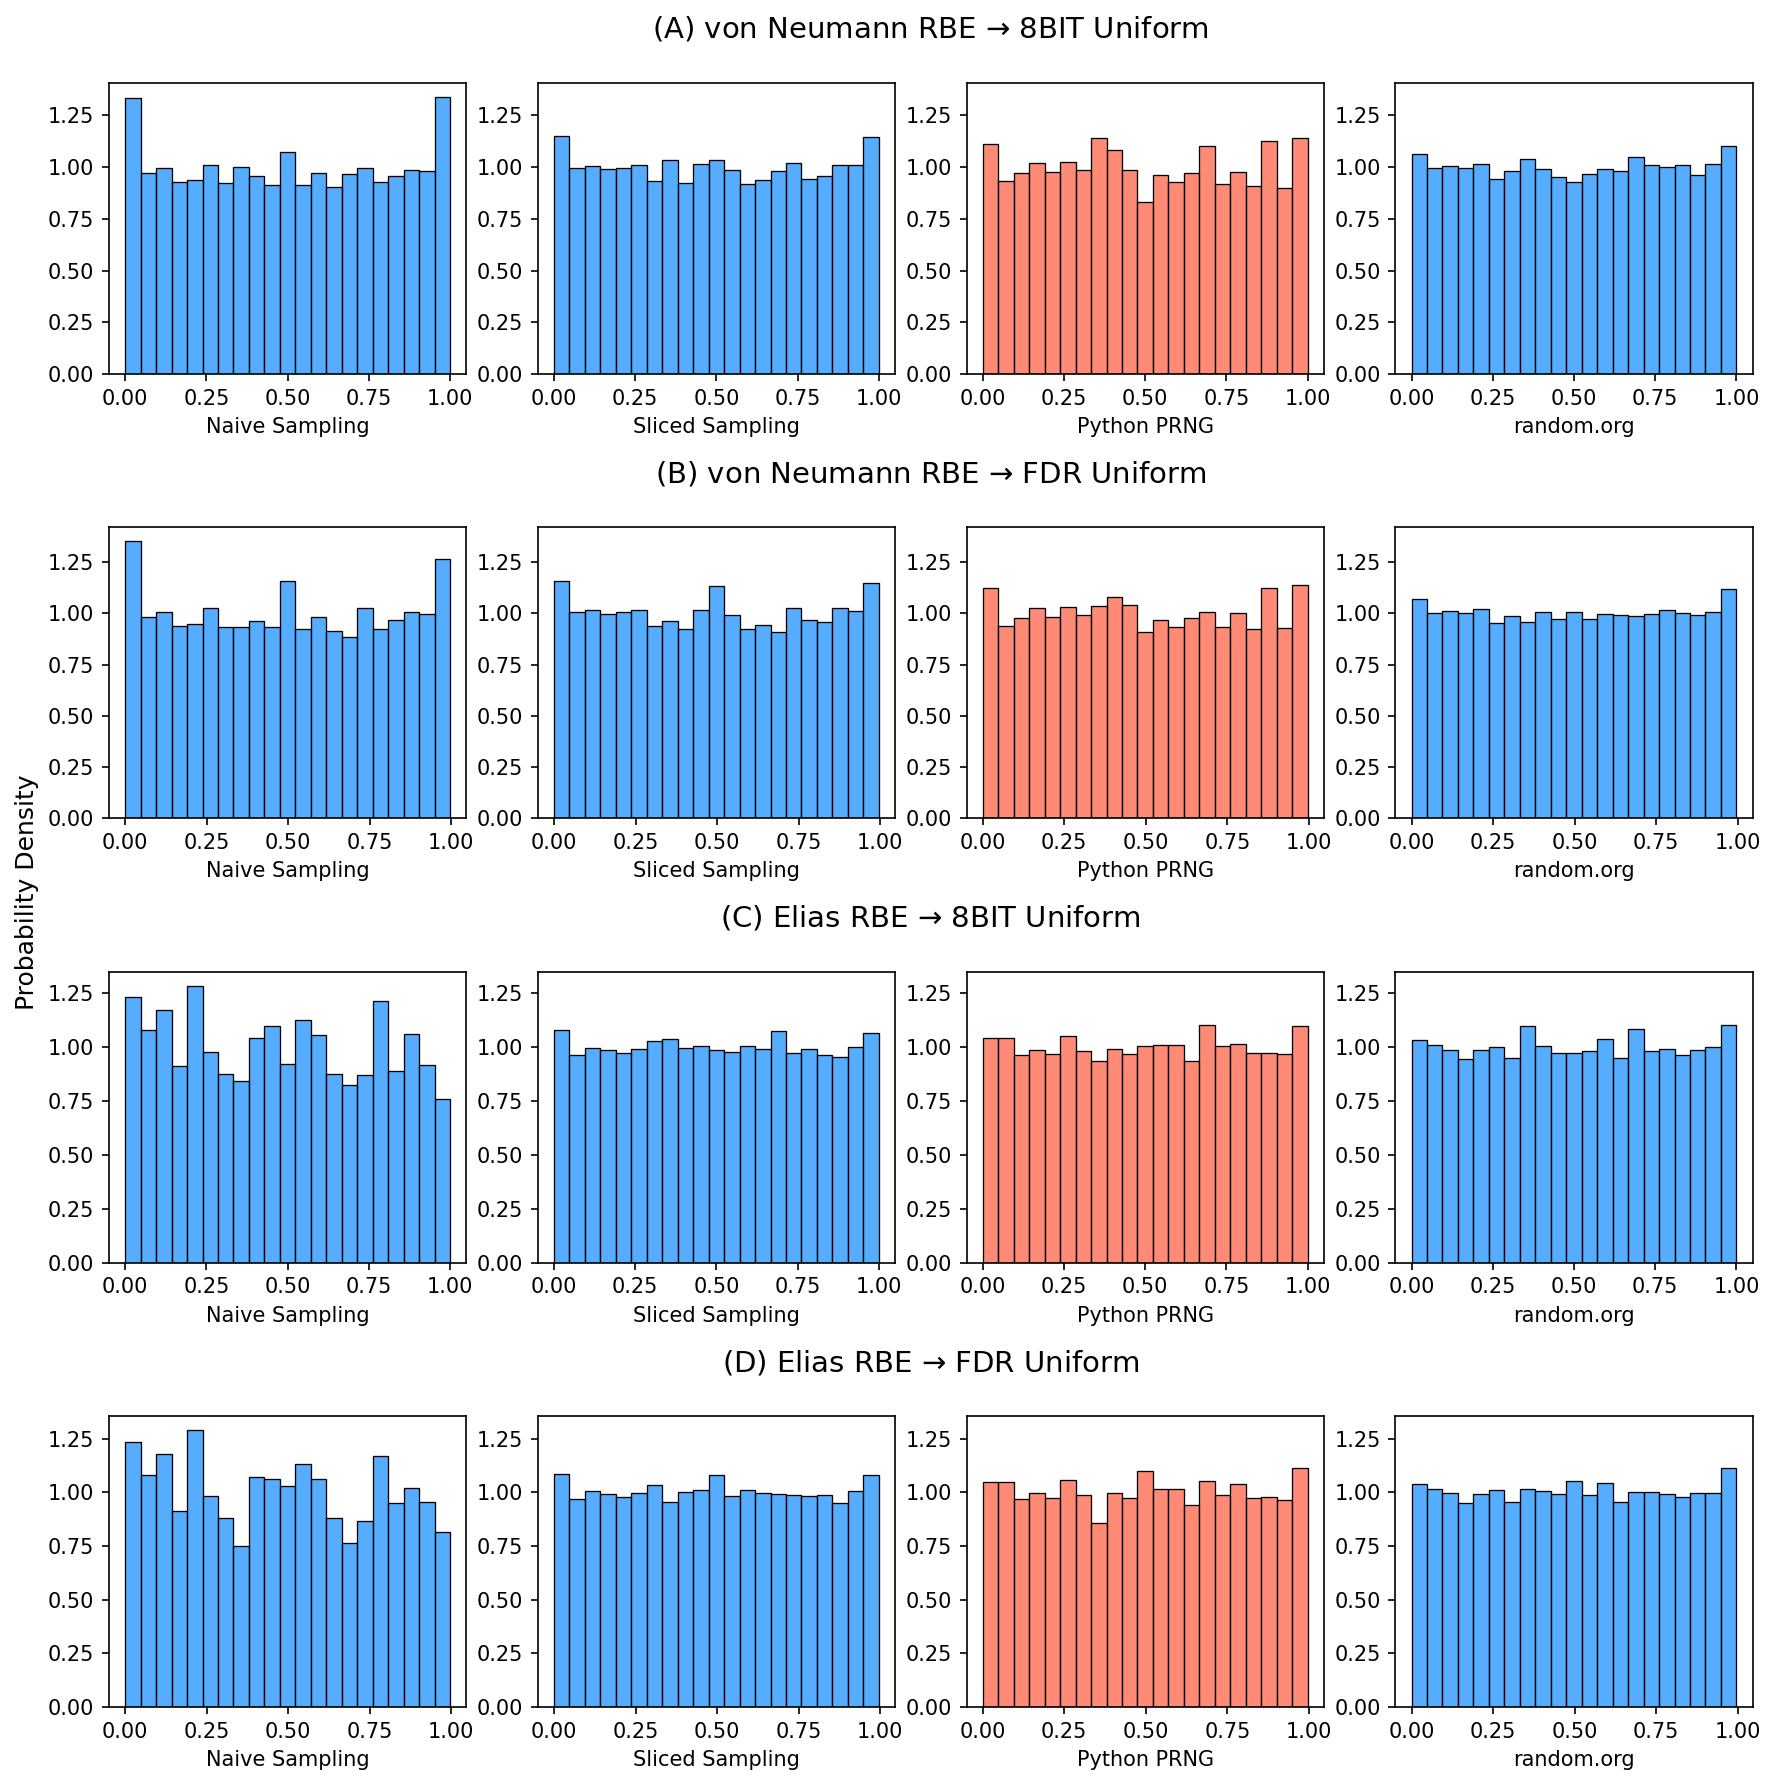

In [287]:
import matplotlib.gridspec as gridspec
x_prng, y_prng = np.random.normal(0, 1, 100000), np.random.normal(0, 1, 100000)

fig = plt.figure(figsize=(12, 12), dpi=150)
grid = plt.GridSpec(4, 1)

for i in range(4):
    # create fake subplot just to title set of subplots
    fake = fig.add_subplot(grid[i])
    if i == 0:
        fake.set_title(r'(A) von Neumann RBE $\to$ 8BIT Uniform'+f'\n', size=14)
        fake.set_axis_off()
        rbe_method='VN'
        unif_method='8BIT'
    elif i == 1:
        fake.set_title(r'(B) von Neumann RBE $\to$ FDR Uniform'+f'\n', size=14)
        fake.set_axis_off()
        rbe_method='VN'
        unif_method='FDR'
    elif i == 2:
        fake.set_title(r'(C) Elias RBE $\to$ 8BIT Uniform'+f'\n', size=14)
        fake.set_axis_off()
        rbe_method='EL'
        unif_method='8BIT'
    elif i == 3:
        fake.set_title(r'(D) Elias RBE $\to$ FDR Uniform'+f'\n', size=14)
        fake.set_axis_off()
        rbe_method='EL'
        unif_method='FDR'

    # create subgrid for two subplots without space between them
    # <https://matplotlib.org/2.0.2/users/gridspec.html>
    gs = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=grid[i])
    
    # real subplot #1
    ax = fig.add_subplot(gs[0])
    x, y = method[1].real, method[1].imag
    uniforms = bits_to_unif(x,y,rbe_method=rbe_method,unif_method=unif_method)
    df = pd.DataFrame()
    df['vals'] = uniforms
    sns.histplot(data=df, x='vals', bins=21, stat="density", ax=ax, color='dodgerblue')
    ax.set_xlabel(r'Naive Sampling')
    ax.set_ylabel('')

    # real subplot #2
    ax = fig.add_subplot(gs[1], sharey=ax)
    x, y = method[2].real, method[2].imag
    uniforms = bits_to_unif(x,y,rbe_method,unif_method=unif_method)
    df = pd.DataFrame()
    df['vals'] = uniforms
    sns.histplot(data=df, x='vals', bins=21, stat="density", ax=ax, color='dodgerblue')
    ax.set_xlabel(r'Sliced Sampling')
    ax.set_ylabel('')

    # real subplot #3
    ax = fig.add_subplot(gs[2], sharey=ax)
    x, y = x_prng, y_prng
    uniforms = bits_to_unif(x,y,rbe_method,unif_method=unif_method)
    df = pd.DataFrame()
    df['vals'] = uniforms
    sns.histplot(data=df, x='vals', bins=21, stat="density", ax=ax, color='tomato')
    ax.set_xlabel('Python PRNG')
    ax.set_ylabel('')

    # real subplot #4
    ax = fig.add_subplot(gs[3], sharey=ax)
    split = np.array_split(method[3]['random_org'].tolist(),2)
    x, y = split[0], split[1]
    uniforms = bits_to_unif(x,y,rbe_method,unif_method=unif_method)
    df = pd.DataFrame()
    df['vals'] = uniforms
    sns.histplot(data=df, x='vals', bins=21, stat="density", ax=ax, color='dodgerblue')
    ax.set_xlabel('random.org')
    ax.set_ylabel('')
    
fig.supylabel('Probability Density')
fig.patch.set_facecolor('white')
fig.tight_layout()
plt.show()
# plt.savefig('bits_to_unif.png')

We see that the Elias RBE outperforms the von Neumann RBE. Although, between the FDR and the 8-bit uniform transformations, both methods are worse than random.org.

## 4. NIST Testing Suite

Now, we test the 4 samples above using the [NIST Testing Suite](https://nvlpubs.nist.gov/nistpubs/Legacy/SP/nistspecialpublication800-22r1a.pdf), which is a battery of 15 tests. The Python implementation of the test suite has been built by [stevenang](https://github.com/stevenang/randomness_testsuite) and is imported here from GitHub. Some adaptations have been made for it to work with our data and versions of various libraries.


In [351]:
%load_ext autoreload
%autoreload 2
from nist import nist

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [780]:
integer_bits = {}
string_bits = {}

# get Elias mapped data
x,y = method[2].real, method[2].imag
integer_bits[1] = rbe(x,y,method='EL',verbose=False)
string_bits[1] = [str(i) for i in integer_bits[1]]
n = len(integer_bits[1])

# get the same amount of random.org data (but no RBE)
integer_bits[2] = method[3]['random_org'][:n]
string_bits[2] = [str(i) for i in integer_bits[2]]

# get the same amount of PRNG data (but no RBE)
import random
# for reproducibility
random.seed(123)
integer_bits[3] = [random.randint(0,1) for i in range(n)]
string_bits[3] = [str(i) for i in integer_bits[3]]

<ipython-input-123-f2b94a2e489e>:42: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bits = np.array([el_map[x] for x in u])[inv].reshape(xybits.shape)


In [772]:
sts = nist()

Significance level set to 0.99


#### Frequency (Monobit) Test

In [758]:
help(sts.monobit_test)

Help on method monobit_test in module nist:

monobit_test(binary_data, verbose=False) method of nist.nist instance
    The focus of the test is the proportion of zeroes and ones for the entire sequence.
    The purpose of this test is to determine whether the number of ones and zeros in a sequence are approximately
    the same as would be expected for a truly random sequence. The test assesses the closeness of the fraction of
    ones to zeroes, that is, the number of ones and zeroes in a sequence should be about the same.
    All subsequent tests depend on the passing of this test.
    if p_value < alpha, then conclude that the sequence is non-random (return False).
    Otherwise, conclude that the the sequence is random (return True).
    :param      binary_data         The sequence of bit being tested
    :param      verbose             True to display the debug messgae, False to turn off debug message
    :return:    (p_value, bool)     A tuple which contain the p_value and result

In [773]:
sts.monobit_test(string_bits[1], verbose=True)

Frequency Test (Monobit Test) DEBUG BEGIN:
	Length of input:	 847878
	# of '0':			 423672
	# of '1':			 424206
	S(n):				 534
	sObs:				 0.5799286621557239
	f:					 0.4100714896147547
	P-Value:			 0.5619627261729967
DEBUG END.


(0.5619627261729967, True)

#### Frequency Test within a Block

In [682]:
help(sts.block_frequency)

Help on method block_frequency in module nist:

block_frequency(binary_data: str, block_size=128, verbose=False) method of builtins.type instance
    The focus of the test is the proportion of ones within M-bit blocks.
    The purpose of this test is to determine whether the frequency of ones in an M-bit block is approximately M/2,
    as would be expected under an assumption of randomness.
    For block size M=1, this test degenerates to test 1, the Frequency (Monobit) test.
    :param      binary_data:        The length of each block
    :param      block_size:         The sequence of bit being tested
    :param      verbose             True to display the debug messgae, False to turn off debug message
    :return:    (p_value, bool)     A tuple which contain the p_value and result of frequency_test(True or False)



In [683]:
sts.block_frequency(string_bits[1], block_size=2**10, verbose=True)

Frequency Test (Block Frequency Test) DEBUG BEGIN:
	Length of input:	 847930
	Size of Block:		 1024
	Number of Blocks:	 828
	CHI Squared:		 832.48046875
	1st:				 414.0
	2nd:				 416.240234375
	P-Value:			 0.4497553169872812
DEBUG END.


(0.4497553169872812, True)

####  Runs Test

In [684]:
help(sts.run_test)

Help on method run_test in module nist:

run_test(binary_data: str, verbose=False) method of builtins.type instance
    The focus of this test is the total number of runs in the sequence,
    where a run is an uninterrupted sequence of identical bits.
    A run of length k consists of exactly k identical bits and is bounded before
    and after with a bit of the opposite value. The purpose of the runs test is to
    determine whether the number of runs of ones and zeros of various lengths is as
    expected for a random sequence. In particular, this test determines whether the
    oscillation between such zeros and ones is too fast or too slow.
    :param      binary_data:        The sequence of bit being tested
    :param      verbose             True to display the debug messgae, False to turn off debug message
    :return:    (p_value, bool)     A tuple which contain the p_value and result of frequency_test(True or False)



In [685]:
sts.run_test(string_bits[1], verbose=True)

Run Test DEBUG BEGIN:
	Length of input:				 847930
	Tau (2/sqrt(length of input)):	 0.0021719508598636176
	# of '1':						 423917
	# of '0':						 424013
	PI (1 count / length of input):	 0.49994339155354806
	vObs:							 424271
	P-Value:						 0.506287959951736
DEBUG END.


(0.506287959951736, True)

#### Test for the Longest Run of Ones in a Block

In [686]:
help(sts.longest_one_block_test)

Help on method longest_one_block_test in module nist:

longest_one_block_test(binary_data: str, verbose=False) method of builtins.type instance
    The focus of the test is the longest run of ones within M-bit blocks. The purpose of this test is to determine
    whether the length of the longest run of ones within the tested sequence is consistent with the length of the
    longest run of ones that would be expected in a random sequence. Note that an irregularity in the expected
    length of the longest run of ones implies that there is also an irregularity in the expected length of the
    longest run of zeroes. Therefore, only a test for ones is necessary.
    :param      binary_data:        The sequence of bits being tested
    :param      verbose             True to display the debug messgae, False to turn off debug message
    :return:    (p_value, bool)     A tuple which contain the p_value and result of frequency_test(True or False)



In [687]:
sts.longest_one_block_test(string_bits[1], verbose=True)

Run Test (Longest Run of Ones in a Block) DEBUG BEGIN:
	Length of input:				 847930
	Size of each Block:				 10000
	Number of Block:				 84
	Value of K:						 6
	Value of PIs:					 [0.0882, 0.2092, 0.2483, 0.1933, 0.1208, 0.0675, 0.0727]
	Frequencies:					 [12. 23. 18. 12. 11.  4.  4.]
	xObs:							 7.308787034777211
	P-Value:						 0.2932322460151605
DEBUG END.


(0.2932322460151605, True)

#### Binary Matrix Rank Test

In [688]:
help(sts.binary_matrix_rank_text)

Help on method binary_matrix_rank_text in module nist:

binary_matrix_rank_text(binary_data: str, verbose=False, rows_in_matrix=32, columns_in_matrix=32) method of builtins.type instance
    Note that this description is taken from the NIST documentation [1]
    [1] http://csrc.nist.gov/publications/nistpubs/800-22-rev1a/SP800-22rev1a.pdf
    The focus of the test is the rank of disjoint sub-matrices of the entire sequence. The purpose of this test is
    to check for linear dependence among fixed length sub strings of the original sequence. Note that this test
    also appears in the DIEHARD battery of tests.
    :param      binary_data         The sequence of bits being tested
    :param      verbose             True to display the debug messgae, False to turn off debug message
    :param      rows_in_matrix      Fixed for 32
    :param      columns_in_matrix   Fixed for 32
    :return     (p_value, bool)     A tuple which contain the p_value and result of frequency_test(True or Fals

In [689]:
sts.binary_matrix_rank_text(integer_bits[1], verbose=True)

Binary Matrix Rank Test DEBUG BEGIN:
	Length of input:	 847878
	Size of Row:		 32
	Size of Column:		 32
	Value of N:			 828
	Value of Pi:		 [0.2887880950866029, 0.5775761901732058, 0.1336357147401913]
	Observed ranks:		 [234, 474, 120]
	Value of xObs:		 0.9369672699062426
	P-Value:			 0.6259507187934101
DEBUG END.


(0.6259507187934101, True)

#### Discrete Fourier Transform (Spectral) Test

In [690]:
help(sts.spectral_test)

Help on method spectral_test in module nist:

spectral_test(binary_data: str, verbose=False) method of builtins.type instance
    Note that this description is taken from the NIST documentation [1]
    [1] http://csrc.nist.gov/publications/nistpubs/800-22-rev1a/SP800-22rev1a.pdf
    The focus of this test is the peak heights in the Discrete Fourier Transform of the sequence. The purpose of
    this test is to detect periodic features (i.e., repetitive patterns that are near each other) in the tested
    sequence that would indicate a deviation from the assumption of randomness. The intention is to detect whether
    the number of peaks exceeding the 95 % threshold is significantly different than 5 %.
    :param      binary_data:        The sequence of bit being tested
    :param      verbose             True to display the debug messgae, False to turn off debug message
    :return:    (p_value, bool)     A tuple which contain the p_value and result of frequency_test(True or False)



In [691]:
sts.spectral_test(string_bits[1], verbose=True)

Discrete Fourier Transform (Spectral) Test DEBUG BEGIN:
	Length of Binary Data:	 847930
	Value of T:				 1593.7914752923718
	Value of n1:			 402854
	Value of n0:			 402766.75
	Value of d:				 0.8694980772789845
	P-Value:				 0.3845747592696981
DEBUG END.


(0.3845747592696981, True)

#### Non-overlapping Template Matching Test 

In [692]:
help(sts.non_overlapping_test)

Help on method non_overlapping_test in module nist:

non_overlapping_test(binary_data: str, verbose=False, template_pattern='000000001', block=8) method of builtins.type instance
    Note that this description is taken from the NIST documentation [1]
    [1] http://csrc.nist.gov/publications/nistpubs/800-22-rev1a/SP800-22rev1a.pdf
    The focus of this test is the number of occurrences of pre-specified target strings. The purpose of this
    test is to detect generators that produce too many occurrences of a given non-periodic (aperiodic) pattern.
    For this test and for the Overlapping Template Matching test of Section 2.8, an m-bit window is used to
    search for a specific m-bit pattern. If the pattern is not found, the window slides one bit position. If the
    pattern is found, the window is reset to the bit after the found pattern, and the search resumes.
    :param      binary_data:        The sequence of bit being tested
    :param      template_pattern:   The pattern to mat

In [693]:
sts.non_overlapping_test(string_bits[3], verbose=True)

Non-Overlapping Template Test DEBUG BEGIN:
	Length of input:		 847930
	Value of Mean (µ):		 206.998046875
	Value of Variance(σ):	 200.1401710510254
	Value of W:				 [193. 201. 208. 218. 186. 201. 192. 202.]
	Value of xObs:			 5.400141216487888
	P-Value:				 0.7140766087191006
DEBUG END.


(0.7140766087191006, True)

#### Overlapping Template Matching Test

In [694]:
help(sts.overlapping_patterns)

Help on method overlapping_patterns in module nist:

overlapping_patterns(binary_data: str, verbose=False, pattern_size=9, block_size=1032) method of builtins.type instance
    Note that this description is taken from the NIST documentation [1]
    [1] http://csrc.nist.gov/publications/nistpubs/800-22-rev1a/SP800-22rev1a.pdf
    The focus of the Overlapping Template Matching test is the number of occurrences of pre-specified target
    strings. Both this test and the Non-overlapping Template Matching test of Section 2.7 use an m-bit
    window to search for a specific m-bit pattern. As with the test in Section 2.7, if the pattern is not found,
    the window slides one bit position. The difference between this test and the test in Section 2.7 is that
    when the pattern is found, the window slides only one bit before resuming the search.
    :param      binary_data:    a binary string
    :param      verbose         True to display the debug messgae, False to turn off debug message
  

In [695]:
sts.overlapping_patterns(string_bits[1], verbose=True)

Overlapping Template Test DEBUG BEGIN:
	Length of input:		 847930
	Value of Vs:			 [301. 163. 129.  77.  54.  97.]
	Value of xObs:			 6.5839135873389285
	P-Value:				 0.2534688905689141
DEBUG END.


(0.2534688905689141, True)

#### Maurer’s “Universal Statistical” Test

In [696]:
help(sts.statistical_test)

Help on method statistical_test in module nist:

statistical_test(binary_data: str, verbose=False) method of builtins.type instance
    Note that this description is taken from the NIST documentation [1]
    [1] http://csrc.nist.gov/publications/nistpubs/800-22-rev1a/SP800-22rev1a.pdf
    The focus of this test is the number of bits between matching patterns (a measure that is related to the
    length of a compressed sequence). The purpose of the test is to detect whether or not the sequence can be
    significantly compressed without loss of information. A significantly compressible sequence is considered
    to be non-random. **This test is always skipped because the requirements on the lengths of the binary
    strings are too high i.e. there have not been enough trading days to meet the requirements.
    :param      binary_data:    a binary string
    :param      verbose             True to display the debug messgae, False to turn off debug message
    :return:    (p_value, bool) 

In [697]:
sts.statistical_test(string_bits[1], verbose=True)

Maurer's Universal Statistical Test DEBUG BEGIN:
	Length of input:		 847930
	Length of each block:	 6
	Number of Blocks:		 640
	Value of phi:			 5.211984430818345
	P-Value:				 0.02804226293853768
DEBUG END.


(0.02804226293853768, True)

#### Linear Complexity Test 

In [698]:
help(sts.linear_complexity_test)

Help on method linear_complexity_test in module nist:

linear_complexity_test(binary_data: str, verbose=False, block_size=500) method of builtins.type instance
    Note that this description is taken from the NIST documentation [1]
    [1] http://csrc.nist.gov/publications/nistpubs/800-22-rev1a/SP800-22rev1a.pdf
    The focus of this test is the length of a linear feedback shift register (LFSR). The purpose of this test is to
    determine whether or not the sequence is complex enough to be considered random. Random sequences are
    characterized by longer LFSRs. An LFSR that is too short implies non-randomness.
    :param      binary_data:    a binary string
    :param      verbose         True to display the debug messgae, False to turn off debug message
    :param      block_size:     Size of the block
    :return:    (p_value, bool) A tuple which contain the p_value and result of frequency_test(True or False)



In [699]:
sts.linear_complexity_test(string_bits[1], verbose=True) # can sometimes take ~30 seconds

Linear Complexity Test DEBUG BEGIN:
	Length of input:	 847930
	Length in bits of a block:	
	Degree of Freedom:		 6
	Number of Blocks:	 1695
	Value of Vs:		 [ 18  48 215 860 434  87  33]
	xObs:				 4.48475836556747
	P-Value:			 0.6113732916947427
DEBUG END.


(0.6113732916947427, True)

#### Serial Test

In [700]:
help(sts.serial_test)

Help on method serial_test in module nist:

serial_test(binary_data: str, verbose=False, pattern_length=16, single_result=True) method of builtins.type instance
    From the NIST documentation http://csrc.nist.gov/publications/nistpubs/800-22-rev1a/SP800-22rev1a.pdf
    The focus of this test is the frequency of all possible overlapping m-bit patterns across the entire
    sequence. The purpose of this test is to determine whether the number of occurrences of the 2m m-bit
    overlapping patterns is approximately the same as would be expected for a random sequence. Random
    sequences have uniformity; that is, every m-bit pattern has the same chance of appearing as every other
    m-bit pattern. Note that for m = 1, the Serial test is equivalent to the Frequency test of Section 2.1.
    :param      binary_data:        a binary string
    :param      verbose             True to display the debug message, False to turn off debug message
    :param      pattern_length:     the length of 

In [701]:
sts.serial_test(string_bits[1], verbose=True, single_result=False)

Serial Test DEBUG BEGIN:
	Length of input:	 847930
	Value of Sai:		 [66297.2386447  33542.60971071 17058.55858385]
	Value of Nabla:		 32754.628933992237 16270.577807130408
	P-Value 01:			 0.5197928041037896
	P-Value 02:			 0.733798419454117
DEBUG END.


((0.5197928041037896, True), (0.733798419454117, True))

#### Approximate Entropy Test

In [702]:
help(sts.approximate_entropy_test)

Help on method approximate_entropy_test in module nist:

approximate_entropy_test(binary_data: str, verbose=False, pattern_length=10) method of builtins.type instance
    from the NIST documentation http://csrc.nist.gov/publications/nistpubs/800-22-rev1a/SP800-22rev1a.pdf
    As with the Serial test of Section 2.11, the focus of this test is the frequency of all possible
    overlapping m-bit patterns across the entire sequence. The purpose of the test is to compare
    the frequency of overlapping blocks of two consecutive/adjacent lengths (m and m+1) against the
    expected result for a random sequence.
    :param      binary_data:        a binary string
    :param      verbose             True to display the debug message, False to turn off debug message
    :param      pattern_length:     the length of the pattern (m)
    :return:    ((p_value1, bool), (p_value2, bool)) A tuple which contain the p_value and result of serial_test(True or False)



In [703]:
sts.approximate_entropy_test(string_bits[1], verbose=True)

Approximate Entropy Test DEBUG BEGIN:
	Length of input:			 847945
	Length of each block:		 10
	ApEn(m):					 0.6925024687544692
	xObs:						 1093.3603037888543
	P-Value:					 0.0650113209050817
DEBUG END.


(0.0650113209050817, True)

#### Cumulative Sums (Cusum) Test

In [704]:
help(sts.cumulative_sums_test)

Help on method cumulative_sums_test in module nist:

cumulative_sums_test(binary_data: str, mode=0, verbose=False) method of builtins.type instance
    from the NIST documentation http://csrc.nist.gov/publications/nistpubs/800-22-rev1a/SP800-22rev1a.pdf
    The focus of this test is the maximal excursion (from zero) of the random walk defined by the cumulative sum of
    adjusted (-1, +1) digits in the sequence. The purpose of the test is to determine whether the cumulative sum of
    the partial sequences occurring in the tested sequence is too large or too small relative to the expected
    behavior of that cumulative sum for random sequences. This cumulative sum may be considered as a random walk.
    For a random sequence, the excursions of the random walk should be near zero. For certain types of non-random
    sequences, the excursions of this random walk from zero will be large.
    :param      binary_data:    a binary string
    :param      mode            A switch for applying

In [705]:
sts.cumulative_sums_test(string_bits[1], verbose=True)

Cumulative Sums Test DEBUG BEGIN:
	Length of input:	 847956
	Mode:				 0
	Value of z:			 1241.0
	P-Value:			 0.3554204389984723
DEBUG END.


(0.3554204389984723, True)

####  Random Excursions Test

In [706]:
help(sts.random_excursions_test)

Help on method random_excursions_test in module nist:

random_excursions_test(binary_data: str, verbose=False, single_result=True) method of builtins.type instance
    from the NIST documentation http://nvlpubs.nist.gov/nistpubs/Legacy/SP/nistspecialpublication800-22r1a.pdf
    The focus of this test is the total number of times that a particular state is visited (i.e., occurs) in a
    cumulative sum random walk. The purpose of this test is to detect deviations from the expected number
    of visits to various states in the random walk. This test is actually a series of eight tests (and
    conclusions), one test and conclusion for each of the states: -4, -3, -2, -1, +1, +2, +3 and +4.
    :param      binary_data:    a binary string
    :param      verbose         True to display the debug messgae, False to turn off debug message
    :return:    (p_value, bool) A tuple which contain the p_value and result of frequency_test(True or False)



In [707]:
sts.random_excursions_test(string_bits[1], verbose=True)

Random Excursion Test DEBUG BEGIN:
	Length of input:	 847956
		 STATE 			 xObs 						 p_value  					 Result
		 -4  		  3.627220353754337  		     0.6042309668263959  			  True
		 -3  		  2.328913757225434  		     0.8020110312588435  			  True
		 -2  		  0.17513737243987723  		     0.9993584846916934  			  True
		 -1  		  4.949132947976878  		     0.4221196018047618  			  True
		  1  		  1.252023121387283  		     0.9397901651454971  			  True
		  2  		  3.228016841504317  		     0.6648789899435461  			  True
		  3  		  7.032192369942193  		    0.21825711008823237  			  True
		  4  		  10.885987774843333  		    0.05368796099266919  			  True
DEBUG END.


(0.05368796099266919, True)

####  Random Excursions Variant Test

In [708]:
help(sts.variant_test)

Help on method variant_test in module nist:

variant_test(binary_data: str, verbose=False, single_result=True) method of builtins.type instance
    from the NIST documentation http://nvlpubs.nist.gov/nistpubs/Legacy/SP/nistspecialpublication800-22r1a.pdf
    :param binary_data:
    :param verbose:
    :return:



In [709]:
sts.variant_test(string_bits[1], verbose=True)

Random Excursion Variant Test DEBUG BEGIN:
	Length of input:	 847956
	Value of j:		 865
	P-Values:
		 STATE 		 COUNTS 		 P-Value 		 Conclusion
		 -9.0 		 709 		 0.3630040686146705 		 True
		 -8.0 		 736 		 0.4232506796075146 		 True
		 -7.0 		 804 		 0.6841864221532712 		 True
		 -6.0 		 847 		 0.896184498631819 		 True
		 -5.0 		 876 		 0.9297532522521125 		 True
		 -4.0 		 848 		 0.8772299926359453 		 True
		 -3.0 		 866 		 0.9914212573480436 		 True
		 -2.0 		 879 		 0.8459159180710729 		 True
		 -1.0 		 843 		 0.5968528025225264 		 True
		  1.0 		 881 		 0.7004762712757424 		 True
		  2.0 		 909 		 0.5413599574666734 		 True
		  3.0 		 1004 		 0.1350352509945754 		 True
		  4.0 		 1112 		 0.024798497882937413 		 True
		  5.0 		 1157 		 0.01927742885102064 		 True
		  6.0 		 1128 		 0.05658562473253136 		 True
		  7.0 		 1064 		 0.18452139221024944 		 True
		  8.0 		 1014 		 0.35499265806803615 		 True
		  9.0 		 989 		 0.4696431903937657 		 True
DEBUG END.


(0.01927742885102064, True)

#### Run all tests

In [760]:
# how much data do we?
print('Elias:', len(integer_bits[1]))
print('random.org:', len(integer_bits[2]))
print('PRNG:', len(integer_bits[3]))

Elias: 847878
random.org: 847878
PRNG: 847878


In [787]:
# loop through all tests and store the p-value
results = pd.DataFrame(
    columns=[
        'monobit_test',
        'block_frequency',
        'run_test',
        'longest_one_block_test',
        'binary_matrix_rank_text',
        'spectral_test',
        'non_overlapping_test',
        'overlapping_patterns',
        'statistical_test',
        'serial_test',
        'approximate_entropy_test',
        'cumulative_sums_test',
        'random_excursions_test',
        'variant_test'
    ],
    index=[
        [r'$\epsilon_0$',r'$\epsilon_0$',r'$\epsilon_1$',r'$\epsilon_1$',r'$\epsilon_2$',r'$\epsilon_2$'],
        [r'$p$-value', 'result', r'$p$-value', 'result', r'$p$-value', 'result']
    ]
)
results = results.T
sts = nist()
tests = {
    'monobit_test':sts.monobit_test,
    'block_frequency':sts.block_frequency,
    'run_test':sts.run_test,
    'longest_one_block_test':sts.longest_one_block_test,
    'binary_matrix_rank_text':sts.binary_matrix_rank_text,
    'spectral_test':sts.spectral_test,
    'non_overlapping_test':sts.non_overlapping_test,
    'overlapping_patterns':sts.overlapping_patterns,
    'statistical_test':sts.statistical_test,
    'serial_test':sts.serial_test,
    'approximate_entropy_test':sts.approximate_entropy_test,
    'cumulative_sums_test':sts.cumulative_sums_test,
    'random_excursions_test':sts.random_excursions_test,
    'variant_test':sts.variant_test
}

for i in [1,2,3]:
    for j in results.index:
        try:
            k = tests[j](string_bits[i])
        except:
            k = tests[j](integer_bits[i])
        results.loc[j,r'$\epsilon_{}$'.format(i-1)][r'$p$-value'] = k[0]
        results.loc[j,r'$\epsilon_{}$'.format(i-1)]['result'] = k[1]
results

Significance level set to 0.99


$\epsilon_0$        $\epsilon_1$        $\epsilon_2$  \
                            $p$-value result    $p$-value result    $p$-value   
monobit_test                 0.922144   True     0.662444   True     0.547439   
block_frequency              0.981573   True     0.625227   True     0.330305   
run_test                     0.461568   True     0.107587   True     0.759728   
longest_one_block_test       0.293232   True     0.284535   True      0.75882   
binary_matrix_rank_text      0.625951   True     0.460013   True     0.984521   
spectral_test                0.699017   True     0.223323   True     0.555234   
non_overlapping_test        0.0904643   True     0.831209   True     0.423487   
overlapping_patterns         0.253469   True     0.739162   True     0.339093   
statistical_test            0.0218578   True     0.222478   True     0.454065   
serial_test                  0.471051   True     0.459778   True     0.620377   
approximate_entropy_test      0.06549   True     0.637154   True     0.964507   
cumulative_sums_test          0.35546   True     0.744599   True     0.945624   
random_excursions_test       0.053688   True    0.0683624   True     0.570841   
variant_test                0.0192774   True       0.0118   True     0.185021   

                                 
                         result  
monobit_test               True  
block_frequency            True  
run_test                   True  
longest_one_block_test     True  
binary_matrix_rank_text    True  
spectral_test              True  
non_overlapping_test       True  
overlapping_patterns       True  
statistical_test           True  
serial_test                True  
approximate_entropy_test   True  
cumulative_sums_test       True  
random_excursions_test     True  
variant_test               True

In [788]:
# for use in the the paper
print(results.to_latex())

\begin{tabular}{lllllll}
\toprule
{} & \multicolumn{2}{l}{\$\textbackslash epsilon\_0\$} & \multicolumn{2}{l}{\$\textbackslash epsilon\_1\$} & \multicolumn{2}{l}{\$\textbackslash epsilon\_2\$} \\
{} &    \$p\$-value & result &    \$p\$-value & result &    \$p\$-value & result \\
\midrule
monobit\_test             &     0.922144 &   True &     0.662444 &   True &     0.547439 &   True \\
block\_frequency          &     0.981573 &   True &     0.625227 &   True &     0.330305 &   True \\
run\_test                 &     0.461568 &   True &     0.107587 &   True &     0.759728 &   True \\
longest\_one\_block\_test   &     0.293232 &   True &     0.284535 &   True &      0.75882 &   True \\
binary\_matrix\_rank\_text  &     0.625951 &   True &     0.460013 &   True &     0.984521 &   True \\
spectral\_test            &     0.699017 &   True &     0.223323 &   True &     0.555234 &   True \\
non\_overlapping\_test     &    0.0904643 &   True &     0.831209 &   True &     0.423487 &   True \\

|                          |   ('$\\epsilon_0$', '$p$-value') |   ('$\\epsilon_0$', 'result') |   ('$\\epsilon_1$', '$p$-value') |   ('$\\epsilon_1$', 'result') |   ('$\\epsilon_2$', '$p$-value') |   ('$\\epsilon_2$', 'result') |
|:-------------------------|---------------------------------:|------------------------------:|---------------------------------:|------------------------------:|---------------------------------:|------------------------------:|
| monobit_test             |                        0.922144  |                             1 |                        0.662444  |                             1 |                         0.547439 |                             1 |
| block_frequency          |                        0.981573  |                             1 |                        0.625227  |                             1 |                         0.330305 |                             1 |
| run_test                 |                        0.461568  |                             1 |                        0.107587  |                             1 |                         0.759728 |                             1 |
| longest_one_block_test   |                        0.293232  |                             1 |                        0.284535  |                             1 |                         0.75882  |                             1 |
| binary_matrix_rank_text  |                        0.625951  |                             1 |                        0.460013  |                             1 |                         0.984521 |                             1 |
| spectral_test            |                        0.699017  |                             1 |                        0.223323  |                             1 |                         0.555234 |                             1 |
| non_overlapping_test     |                        0.0904643 |                             1 |                        0.831209  |                             1 |                         0.423487 |                             1 |
| overlapping_patterns     |                        0.253469  |                             1 |                        0.739162  |                             1 |                         0.339093 |                             1 |
| statistical_test         |                        0.0218578 |                             1 |                        0.222478  |                             1 |                         0.454065 |                             1 |
| serial_test              |                        0.471051  |                             1 |                        0.459778  |                             1 |                         0.620377 |                             1 |
| approximate_entropy_test |                        0.06549   |                             1 |                        0.637154  |                             1 |                         0.964507 |                             1 |
| cumulative_sums_test     |                        0.35546   |                             1 |                        0.744599  |                             1 |                         0.945624 |                             1 |
| random_excursions_test   |                        0.053688  |                             1 |                        0.0683624 |                             1 |                         0.570841 |                             1 |
| variant_test             |                        0.0192774 |                             1 |                        0.0118    |                             1 |                         0.185021 |     

In [801]:
dol = 5
gbp = 22.29
ex_rate = 1.37713
random_org_data = dol/ex_rate
gbp/random_org_data

6.13924554

In [800]:
1/1.37713

0.7261478582268922

In [802]:
random_org_data

3.6307392911344607